# Projet numérique 2 : Choix du pas de temps
 

## Question 1 : Euler explicite

In [12]:
##Schéma Euler ordre 1
import matplotlib.pyplot as plt
import numpy as np 

def solve_euler_explicit(f, x0, dt, t_max = 10):
    x=[x0]
    t=[0]
    xj = np.array(x0)
    while t[-1]< t_max: # condition de fin
        xj= xj + dt*np.array(f(xj))
        tj=t[-1]
        x.append(xj)
        t.append(tj+dt)
    return t, x

On teste sur le problème de Cauchy :
\begin{align}
\dot{y}+4y=0, x(0)=1
\end{align} dont la solution est : \begin{align} x \mapsto e^{-4x} \end{align}

In [17]:
import math

def f(x):
    return -4*x

#Solution théorique
def g(x) :
    return math.exp (-4*x)

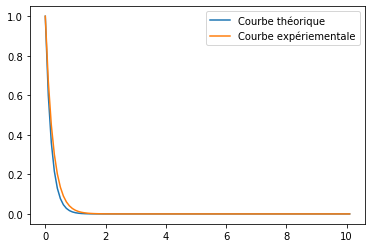

In [18]:
t, x_exp, = solve_euler_explicit(f,1, 10**-1)
x_theo = [g(i) for i in t]
plt.plot(t, x_exp, label = "Courbe théorique")

plt.plot(t, x_theo, label="Courbe expériementale")
plt.legend()
plt.grid
plt.show()


On observe bien une erreur sur le calcul de la solution par la méthode d'Euleur, qui peut être diminuée, ici en réduisant le pas de temps. Nous allons ici illustrer que la convergence du schéma d'Eulet est bien d'ordre 1, en traçant l'erreur absolue maximale de notre simulation en fonction du pas de temps.

In [20]:
# définition d'une fonction recherchant le maximum en valeur absolue

def max(tab) :
    max = abs(tab[0])
    for i in range (len(tab)) :
        if tab[i]>max :
            max = tab[i]
    return max

res = []
for n in range(7) :
    deltat = 10**-n
    temps, resexp = solve_euler_explicit(f,1, deltat)
    restheo = [g(i) for i in temps]
    erreur = np.array(restheo)-np.array(resexp)
    res.append(max(erreur))

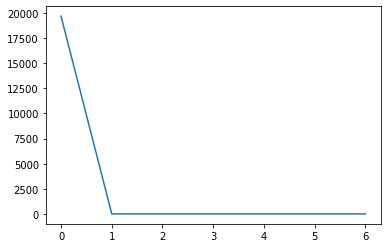

In [22]:
a_tracer = [res[i]/10**-i for i in range(7)]
plt.plot([0, 1, 2, 3, 4, 5, 6], a_tracer)
plt.show()

Pour obtenir une erreur moindre, on peut aussi favoriser une méthode d'ordre 2, c'est ce que l'on va faire avec la méthode de Heun.


## Question 2 : Méthode de Heun

In [15]:
def solve_heun(f,x0,dt, t_max):
    x=np.array(x0)
    t=np.array(0)
    while t[-1] < t_max:
        xj=x[-1]
        tj=t[-1]
        x_approx=xj+np.array(f(xj))*dt
        x.append(xj+(dt/2)*(f(xj)+x_approx))
        t.append(tj+dt)
    return t,x

In [ ]:
les_t, les_x=solve_euler_explicit(f,1, 10**-1)
plt.plot(les_t, les_x)
plt.grid
plt.show()

## Question 3 : démonstration du résultat demandé

On va démontrer le résultat suivant quand f est de classe 1 :
\begin{align}
\left\| e^{j+1} \right\| =\Delta t_{j}  \frac{\left\|f(t_{j+1},\ x^{j+1})-f(t_{j}, \ x^{j})\right\|}{2} + O(\Delta t_{j}^{3})
\end{align}


On va utiliser la définition d'erreur locale, qui nous donne 
\begin{align}
\dot{x} &=& f(x, t) \\ 
x(t_{j}) &=& x^{j}
\end{align}

Ce qui une fois intégré donne : 
\begin{align}
\int_{t_j}^{t_{j+1}} f(s,x(s)) ds = x(t_{j+1}) - x(t_{j})
\end{align}

Puisque f est une fois continûment différentiable, x l'est deux fois, avec une formule de Taylor, on obtient donc : 
\begin{align} x(t_{j+1}) = x(t_{j}+\Delta t_{j}) =x(t_{j}) + \dot{x}(t_{j})\Delta t_{j} +\frac{\ddot{x}(t_{j})}{2}\Delta t_{j}^{2}+O(\Delta t_{j}^{3})\end{align}

Or, \begin{align} x(t_{j}) + \dot{x}(t_{j})\Delta t_{j} = x(t_{j})+ f(t_{j}, x^{j})\Delta t_{j} =x^{j+1}\end{align}

Ce qui permet d'obtenir 
\begin{align}  
e^{j+1} =  x^{j} + \int_{t_j}^{t^{j+1}} f(s,x(s)) ds  - x^{j+1} = \frac{\ddot{x}(t_{j})}{2} \Delta t_{j}^{2}+O(\Delta t_{j}^{3}) 
\end{align}

En développant lorque le pas de temps tend vers 0, il vient d'autre part :


\begin{align}
f(t_{j+1},  x^{j+1}) = f(t_{j} + \Delta t_{j},  x^{j} + \Delta t_{j}f(t_{j},x^{j})) = f(t_{j}, x^{j}) + f'(t_{j})\Delta t_{j} + O(\Delta t_{j}^{2})
\end{align}
Et puisque 
\begin{align}
f'(t_{j}) = \ddot{x}(t_{j})
\end{align}

Ce qui finalement donne :
\begin{align}
 e^{j+1}  =\Delta t_{j}  \frac{f(t_{j+1},\ x^{j+1})-f(t_{j}, \ x^{j})}{2} + O(\Delta t_{j}^{3})
\end{align}

En calculant la norme de l'erreur au carré et en effectuant un développement limité, on montre que l'on peut aussi écrire :
\begin{align}
\left\| e^{j+1} \right\| =\Delta t_{j}  \frac{\left\|f(t_{j+1},\ x^{j+1})-f(t_{j}, \ x^{j})\right\|}{2} + O(\Delta t_{j}^{3})
\end{align}


## Question 4 : Pas de temps optimal 

Question 5: Fonctionnement solveur

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from scipy.integrate import solve_ivp
import matplotlib; 
from matplotlib.pyplot import *
import seaborn as sns
sns.set()
%matplotlib notebook

## Euler explicite à pas variable


In [ ]:
def solve_ivp_euler_explicit_variable_step(f, t0, x0, t_f, dtmin = 1e-16, dtmax = 0.01, atol = 1e-6):
    dt = dtmax/10; # initial integration step
    ts, xs = [t0], [x0]  # storage variables
    t = t0
    ti = 0  # internal time keeping track of time since latest storage point : must remain below dtmax
    x = x0
    while ts[-1] < t_f:
        while ti < dtmax:
            t_next, ti_next, x_next = t + dt, ti + dt, x + dt * f(x)
            x_back = x_next - dt * f(x_next)
            ratio_abs_error = atol / (linalg.norm(x_back-x)/2)
            dt = 0.9 * dt * sqrt(ratio_abs_error)
            if dt < dtmin:
                raise ValueError("Time step below minimum")
            elif dt > dtmax/2:
                dt = dtmax/2
            t, ti, x = t_next, ti_next, x_next
        dt2DT = dtmax - ti # time left to dtmax
        t_next, ti_next, x_next = t + dt2DT, 0, x + dt2DT * f(x)
        ts = vstack([ts,t_next])
        xs = vstack([xs,x_next])
        t, ti, x = t_next, ti_next, x_next
    return (ts, xs.T)

Par exemple, sur un oscillateur, le pas de temps "interne" s'adapte automatiquement à la pulsation $\omega$. Notons que la solution en sortie est toujours échantillonnées à dtmax, donc il faut diminuer ce paramètre si l'on veut plus de précision de visualisation.

In [ ]:
# Oscillateur 

omega = 1

def f(xy):
    x, y = xy
    return array([y, -omega*x])

t0, tf, x0 = 0.0, 30.0, array([-1.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf)

figure()
plot(t, x[0])
plot(t, x[1])
grid(True)

figure()
plot(x[0],x[1])

On constate cependant que les solutions ne suivent pas une ellipse parfaite car l'énergie n'est pas conservée par l'algorithme. Pour ce type de système conservatif, il faudrait en fait un schéma symplectique. Voir plus bas.

## Système raide


Les systèmes raides désignent des systèmes comprenant des dynamiques aux constantes de temps très différentes. Dans ce cas, le pas nécessaire pour simuler avec précision les dynamiques très rapides est si petit, qu'il est alors impossible de simuler assez longtemps pour observer les parties lentes. La particularité de ces systèmes est que cette décroissance du pas apparaît alors que la solution est parfaitement régulière, et non pas proche de singularités.

La coexistence de dynamiques très lentes à très rapides apparaît typiqument en cinétique chimique, par exemple la réaction de Robertson : \begin{align} A & \stackrel{0.04}{\longrightarrow} B \quad \text{(lente)} \ B + B & \stackrel{3 \times 10^7}{\longrightarrow} B + C \quad \text{(très rapide)} \ B + C & \stackrel{10^4}{\longrightarrow} A + C \quad \text{(rapide)} \end{align} modélisée par \begin{align} \dot{x}_a &= -0.04 x_b + 10^4 x_bx_c \ \dot{x}_b &= 0.04 x_a - 10^4 x_bx_c - 3\times 10^7 x_b^2\ \dot{x}_c &= 3\times 10^7 x_b^2 \end{align}

Lorsqu'on applique le schéma d'Euler explicite à pas variable, le compromis précision/pas de temps devient impossible.

In [ ]:
def f(xabc):
    xa, xb, xc = xabc
    return array([-0.04 * xb + 1e4 * xb * xc, 0.04 * xa - 1e4 * xb * xc - 3e7 * xb**2,  3e7 * xb**2])

t0, tf, x0 = 0.0, 5.0, array([1.0, 0.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf, dtmin = 1e-20, atol = 1)

figure()
plot(t, x[0])
plot(t, x[1])
plot(t, x[2])
grid(True)

## Système hamiltonien : exemple d'un problème à deux corps 

Voir exercice "Euler Symplectique"

In [ ]:
e = 0.01
q0 = array([1-e,0.0])
p0 = array([0.0,sqrt((1+e)/(1-e))])
t0, tf, dt = 0.0 , 50.0, 0.01

In [ ]:
def solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf):
    ts, qs, ps = [t0], [q0], [p0]
    while ts[-1] < tf:
        t, q, p = ts[-1], qs[-1], ps[-1]
        t_next, q_next = t + dt, q + dt*fq(p)
        p_next = p + dt*fp(q_next)
        ts = vstack([ts,t_next])
        qs = vstack([qs,q_next])
        ps = vstack([ps,p_next])
    return (ts, qs.T, ps.T)

In [ ]:
def fq(p):
    return p

def fp(q):
    q1, q2 = q
    return array([-q1/power(q1**2+q2**2,3/2),-q2/power(q1**2+q2**2,3/2)])

def fun(qp):
    q1, q2, p1, p2 = qp
    return concatenate([fq([p1,p2]),fp([q1,q2])])

In [ ]:
t, q, p = solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf)

t, qp = solve_ivp_euler_explicit_variable_step(fun, t0, concatenate([q0,p0]), tf)

figure()
plot(q[0], q[1])
plot([0.0],[0.0],'.')
grid(True)
title('Euler symplectique')

figure()
plot(qp[0],qp[1])
plot([0.0],[0.0],'.')
grid(True)
title('Euler explicite pas variable')